### Importando Bibliotecas

In [50]:
#importando bibliotecas
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

#definindo seed - a seed garante que o resultado seja reprodutível
random.seed(42)

# importando bibliotecas de machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Importando a função calcular_distancia e a variável API_KEY do arquivo calcKMs.py
from calcKMs import calcular_distancia, API_KEY 

### Lendo o Dataframe

In [19]:
dados = pd.read_csv("data/df_t.csv")
dados = dados.rename(columns={'nk_ota_localizer_id':'id_pedido',
                                'fk_contact':'id_cliente',
                                'fk_departure_ota_bus_company':'viacao',
                                'gmv_success':'valor_total_compra',
                                'total_tickets_quantity_success':'qtd_passagens'})
dados.head()

,id_pedido,id_cliente,date_purchase,time_purchase,place_origin_departure,place_destination_departure,place_origin_return,place_destination_return,viacao,fk_return_ota_bus_company,valor_total_compra,qtd_passagens
0,bc02d5245bec63b30ff1102fa273fc03f58bc9cc3f674e...,a7218ff4ee7d37d48d2b4391b955627cb089870b934912...,2018-12-26,15:33:35,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,50e9a8665b62c8d68bccc77c7c92431a1aa26ccbd38ed4...,0,0,8527a891e224136950ff32ca212b45bc93f69fbb801c3b...,1,89.09,1
1,5432f12612dd5d749b3be880e779989cf63b5efa4bcc4e...,37228485e0dc83d84d1bcd1bef3dc632301bf6cb22c8b5...,2018-12-05,15:07:57,10e4e7caf8b078429bb1c80b1a10118ac6f963eff098fd...,e6d41d208672a4e50b86d959f4a6254975e6fb9b088116...,0,0,36ebe205bcdfc499a25e6923f4450fa8d48196ceb4fa0c...,1,155.97,1
2,fb3caed9b2f1b6016d45ccddb19095476e61a2c85faa8e...,3467ec081e2421e72c96e7203b929d21927fd00b6b5f28...,2018-12-21,18:41:54,7688b6ef52555962d008fff894223582c484517cea7da4...,8c1f1046219ddd216a023f792356ddf127fce372a72ec9...,0,0,ec2e990b934dde55cb87300629cedfc21b15cd28bbcf77...,1,121.99,1
3,4dc44a6dd592b702feccb493d192210c86965aee684529...,ab3251a2be0f69713b8f97b0e9d1579e31551f4fd4facf...,2018-12-06,14:01:38,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,d6acb3c1a79e57bcc03d976cb4d98f56edccd4cf426392...,0,0,5f9c4ab08cac7457e9111a30e4664920607ea2c115a143...,1,55.22,1
4,aa34ed7fd0a6b405df2df1bf9f8d68e6df9b9a868a6181...,ceea0de820a6379f2c4215bddaec66c33994b304607e56...,2021-02-23,20:08:25,7688b6ef52555962d008fff894223582c484517cea7da4...,23765fc69c4e3c0b10f5d15471dc2245e2a19af16b513f...,0,0,48449a14a4ff7d79bb7a1b6f3d488eba397c36ef25634c...,1,45.31,1


In [20]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741344 entries, 0 to 1741343
Data columns (total 12 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id_pedido                    object 
 1   id_cliente                   object 
 2   date_purchase                object 
 3   time_purchase                object 
 4   place_origin_departure       object 
 5   place_destination_departure  object 
 6   place_origin_return          object 
 7   place_destination_return     object 
 8   viacao                       object 
 9   fk_return_ota_bus_company    object 
 10  valor_total_compra           float64
 11  qtd_passagens                int64  
dtypes: float64(1), int64(1), object(10)
memory usage: 159.4+ MB


In [21]:
# transformando atributos de data e hora
dados['date_purchase'] = pd.to_datetime(dados['date_purchase'])
dados['time_purchase'] = pd.to_datetime(dados['time_purchase'], format='%H:%M:%S').dt.time

### Atribuindo nome aos municípios

In [22]:
# carregando dataframe de municípios 
municipios_df = pd.read_csv("data/municipios_final.csv")
municipios_df.head()

,COD,UF,NOME
0,1100015,RO,Alta Floresta D'oeste
1,1100023,RO,Ariquemes
2,1100031,RO,Cabixi
3,1100049,RO,Cacoal
4,1100056,RO,Cerejeiras


In [23]:
# criando lista de municípios e um map para atribuir o estado corretamente
municipios_list = municipios_df['NOME'].tolist()
municipio_estado_map = dict(zip(municipios_df['NOME'], municipios_df['UF']))

# criando lista de todos os hashs
hash_unico = pd.unique(dados[['place_origin_departure', 'place_destination_departure']].values.ravel())

# embaralha a lista de municípios
random.shuffle(municipios_list)

# atribui um hash para um nome de município aleatório
hash_municipio = dict(zip(hash_unico, municipios_list))

# nomeando municipios
dados['origem'] = dados['place_origin_departure'].map(hash_municipio)
dados['uf_origem'] = dados['origem'].map(municipio_estado_map)

dados['destino'] = dados['place_destination_departure'].map(hash_municipio)
dados['uf_destino'] = dados['destino'].map(municipio_estado_map)

# nomeando municipios - return
dados['origem_retorno'] = dados['place_origin_return'].map(hash_municipio)
dados['destino_retorno'] = dados['place_destination_return'].map(hash_municipio)

# criando coluna de rotas
dados['rota'] = dados['origem'] + ' - ' + dados['destino']
dados['rota_retorno'] = dados['origem_retorno'] + ' - ' + dados['destino_retorno']


dados = dados.drop(columns=['place_origin_departure', 
                            'place_destination_departure',
                            'place_origin_return', 
                            'place_destination_return'])

dados.head()

,id_pedido,id_cliente,date_purchase,time_purchase,viacao,fk_return_ota_bus_company,valor_total_compra,qtd_passagens,origem,uf_origem,destino,uf_destino,origem_retorno,destino_retorno,rota,rota_retorno
0,bc02d5245bec63b30ff1102fa273fc03f58bc9cc3f674e...,a7218ff4ee7d37d48d2b4391b955627cb089870b934912...,2018-12-26,15:33:35,8527a891e224136950ff32ca212b45bc93f69fbb801c3b...,1,89.09,1,Caapiranga,AM,Miraguaí,RS,NaN,NaN,Caapiranga - Miraguaí,NaN
1,5432f12612dd5d749b3be880e779989cf63b5efa4bcc4e...,37228485e0dc83d84d1bcd1bef3dc632301bf6cb22c8b5...,2018-12-05,15:07:57,36ebe205bcdfc499a25e6923f4450fa8d48196ceb4fa0c...,1,155.97,1,São Braz do Piauí,PI,São Rafael,RN,NaN,NaN,São Braz do Piauí - São Rafael,NaN
2,fb3caed9b2f1b6016d45ccddb19095476e61a2c85faa8e...,3467ec081e2421e72c96e7203b929d21927fd00b6b5f28...,2018-12-21,18:41:54,ec2e990b934dde55cb87300629cedfc21b15cd28bbcf77...,1,121.99,1,Lavínia,SP,Campo Erê,SC,NaN,NaN,Lavínia - Campo Erê,NaN
3,4dc44a6dd592b702feccb493d192210c86965aee684529...,ab3251a2be0f69713b8f97b0e9d1579e31551f4fd4facf...,2018-12-06,14:01:38,5f9c4ab08cac7457e9111a30e4664920607ea2c115a143...,1,55.22,1,Taipas do Tocantins,TO,Luiziânia,SP,NaN,NaN,Taipas do Tocantins - Luiziânia,NaN
4,aa34ed7fd0a6b405df2df1bf9f8d68e6df9b9a868a6181...,ceea0de820a6379f2c4215bddaec66c33994b304607e56...,2021-02-23,20:08:25,48449a14a4ff7d79bb7a1b6f3d488eba397c36ef25634c...,1,45.31,1,Lavínia,SP,Santa Rita de Caldas,MG,NaN,NaN,Lavínia - Santa Rita de Caldas,NaN


In [24]:
# listando as 10 rotas mais populares
top_10_rotas = dados['rota'].value_counts().head(10)
top_10_rotas

rota
Caapiranga - Lavínia                 37879
Lavínia - Caapiranga                 35965
Caapiranga - Indiavaí                20075
Indiavaí - Caapiranga                18581
Caapiranga - Santa Rita de Caldas    15391
Formoso - Formoso                    14750
Caapiranga - Taipas do Tocantins     11329
Lavínia - São Sebastião              10938
Taipas do Tocantins - Caapiranga     10466
São Sebastião - Lavínia               9804
Name: count, dtype: int64

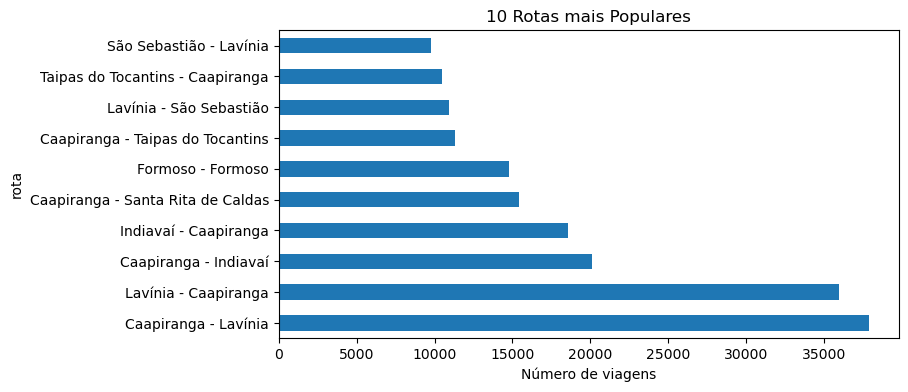

In [25]:
plt.figure(figsize=(8,4))
top_10_rotas.plot(kind='barh')
plt.title("10 Rotas mais Populares")
plt.xlabel("Número de viagens")
plt.show()

In [26]:
# salvando o dataframe tratado para outras análises
df_tratado = dados.copy() 
dados['origem_retorno'].value_counts()

origem_retorno
Caapiranga             17797
Lavínia                16556
Indiavaí                6828
São Sebastião           5604
Taipas do Tocantins     4001
                       ...  
Formosa do Oeste           1
Wenceslau Braz             1
Pará de Minas              1
Lajes Pintadas             1
Piripá                     1
Name: count, Length: 1816, dtype: int64

## Clusterização de Clientes

In [27]:
# calculando o valor da passagem 
dados['valor_passagem'] = dados['valor_total_compra'] / dados['qtd_passagens']

dados = dados.groupby('id_cliente').agg(
    num_compras_distintas = pd.NamedAgg('id_cliente', 'count'), # contagem do número de compras feitas no site
    media_valor_gasto_passagem = pd.NamedAgg('valor_passagem', 'mean'), # media de valor gasto por passagem
    media_valor_gasto_compra = pd.NamedAgg('valor_total_compra', 'mean'), # media de valor gasto por compra no site
    total_gasto = pd.NamedAgg('valor_total_compra', 'sum'), # total gasto no site 
    media_qtd_passagens = pd.NamedAgg('qtd_passagens', 'mean'), # media de passagens a cada compra
    total_passagens_compradas = pd.NamedAgg('qtd_passagens', 'sum'), # total de passagens compradas
    num_viacoes = pd.NamedAgg('viacao', 'nunique'), # numero de viacoes (entender se o cliente é fiel a alguma delas)
    num_rotas = pd.NamedAgg('rota', 'nunique'), # para entender se o cliente sempre faz a mesma rota
    passagem_volta = pd.NamedAgg('rota_retorno', 'count')
    ).reset_index()

In [28]:
dados_clientes = dados.copy()
df_clientes = dados.drop(columns='id_cliente')

df_clientes.head(3)

,num_compras_distintas,media_valor_gasto_passagem,media_valor_gasto_compra,total_gasto,media_qtd_passagens,total_passagens_compradas,num_viacoes,num_rotas,passagem_volta
0,1,91.02,91.02,91.02,1.0,1,1,1,0
1,2,81.00,81.00,162.00,1.0,2,2,2,0
2,1,169.90,169.90,169.90,1.0,1,1,1,0


### Pré processamento de dados

In [29]:
features = df_clientes.columns

# instanciando StandardScaler
scaler = StandardScaler()

# aplicando o escalonamento aos dados
df_clientes_scaled = scaler.fit_transform(df_clientes)
df_clientes_scaled = pd.DataFrame(df_clientes_scaled, columns=features)
df_clientes_scaled.head()

,num_compras_distintas,media_valor_gasto_passagem,media_valor_gasto_compra,total_gasto,media_qtd_passagens,total_passagens_compradas,num_viacoes,num_rotas,passagem_volta
0,-0.261190,-0.368418,-0.538007,-0.241718,-0.586227,-0.293291,-0.443254,-0.410540,-0.218992
1,-0.130133,-0.479946,-0.597752,-0.197852,-0.586227,-0.200852,0.366677,0.053691,-0.218992
2,-0.261190,0.509561,-0.067687,-0.192969,-0.586227,-0.293291,-0.443254,-0.410540,-0.218992
3,0.131983,0.002063,-0.054450,0.127521,0.006712,0.168907,1.176608,0.982155,1.220431
4,-0.130133,-0.719976,-0.726332,-0.224507,-0.586227,-0.200852,0.366677,0.053691,-0.218992


### Elbow para a detecção do número de clusters

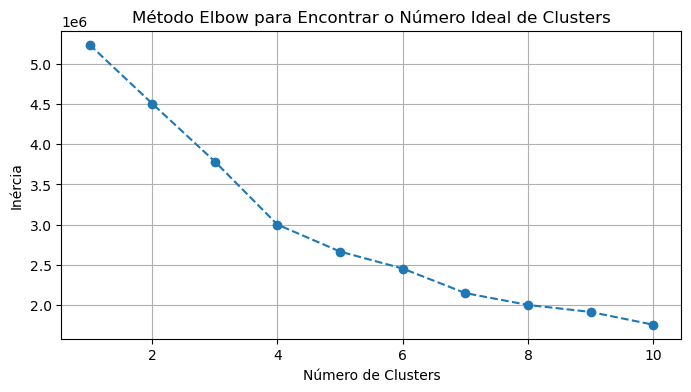

In [30]:
inertia = []

# loop para testar de 1 a 10 clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(df_clientes_scaled)
    inertia.append(kmeans.inertia_)

# Cria o gráfico
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método Elbow para Encontrar o Número Ideal de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.grid(True)
plt.show()

### Kmeans

In [31]:
# analisando o gráfico percebemos que o número ideal de clusters é 4
optimal_clusters = 4

# treinando o modelo 
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42, n_init='auto')
kmeans_optimal.fit(df_clientes_scaled)

# adicionando o rótulos do cluster
df_clientes['cluster'] = kmeans_optimal.labels_

# exibe as médias das variáveis para cada cluster para análise (médias normalizadas)
cluster_analysis = df_clientes.groupby('cluster').mean()
cluster_analysis

,num_compras_distintas,media_valor_gasto_passagem,media_valor_gasto_compra,total_gasto,media_qtd_passagens,total_passagens_compradas,num_viacoes,num_rotas,passagem_volta
cluster,,,,,,,,,
0,17.267651,121.838928,167.597420,2563.440876,1.395520,22.748647,4.776292,6.741757,1.737299
1,2.144364,99.990703,123.763330,259.975993,1.305720,2.768821,1.351544,1.605071,0.153522
2,1.684105,236.080318,450.923588,727.253238,2.398292,3.810582,1.295976,1.418006,0.474677
3,650.280000,167.316966,252.342348,163459.084000,1.546157,1001.680000,41.120000,133.440000,66.400000


In [32]:
df_clientes['cluster'].value_counts(normalize=True)

cluster
1    0.772834
2    0.167749
0    0.059374
3    0.000043
Name: proportion, dtype: float64

In [33]:
# analisando os clusters com os valores antes da normalização
# adicionando os rótulos do cluster a cada registro
dados_clientes['cluster'] = kmeans_optimal.labels_
dados_clientes.head()

,id_cliente,num_compras_distintas,media_valor_gasto_passagem,media_valor_gasto_compra,total_gasto,media_qtd_passagens,total_passagens_compradas,num_viacoes,num_rotas,passagem_volta,cluster
0,0000029b76ad3cf9d86ad430754fb1d4478069affda61e...,1,91.020,91.020,91.02,1.0,1,1,1,0,1
1,000010ae2e13049769982d9f07de792d92452ff1d124e3...,2,81.000,81.000,162.00,1.0,2,2,2,0,1
2,00001f68902d3e8d332baa62a69065ce71e7b5a8c850a5...,1,169.900,169.900,169.90,1.0,1,1,1,0,1
3,00007a5d618cd250d7f05766cfe01a8663a3767f1cd669...,4,124.305,172.120,688.48,1.5,6,3,4,2,1
4,00008c39885815e42a0bb750cee199cd4da741a5645705...,2,59.435,59.435,118.87,1.0,2,2,2,0,1


In [34]:
# calculando as medidas de resumo agora de acordo com cada cluster
resumo_clientes_cluster = dados_clientes.groupby('cluster').describe().T
resumo_clientes_cluster

cluster                                       0              1             2  \
num_compras_distintas      count   34545.000000  449648.000000  97599.000000   
                           mean       17.267651       2.144364      1.684105   
                           std        18.150190       2.074181      1.284280   
                           min         4.000000       1.000000      1.000000   
                           25%         8.000000       1.000000      1.000000   
                           50%        12.000000       1.000000      1.000000   
                           75%        20.000000       2.000000      2.000000   
                           max       437.000000      31.000000     19.000000   
media_valor_gasto_passagem count   34545.000000  449648.000000  97599.000000   
                           mean      121.838928      99.990703    236.080318   
                           std        59.151224      54.175837    134.674961   
                           min         7.284275     -93.385000    -24.042500   
                           25%        77.871538      56.190000    149.295000   
                           50%       114.012667      90.335000    209.455000   
                           75%       154.719583     133.180000    302.000000   
                           max       590.040807     267.547500   1847.480000   
media_valor_gasto_compra   count   34545.000000  449648.000000  97599.000000   
                           mean      167.597420     123.763330    450.923588   
                           std        94.385932      65.558774    238.140269   
                           min         9.239412    -358.930000   -192.340000   
                           25%       100.607857      69.460000    314.230000   
                           50%       150.077778     114.527333    379.025000   
                           75%       213.208182     168.860000    503.872500   
                           max      1119.348085     349.170000   6723.930000   
total_gasto                count   34545.000000  449648.000000  97599.000000   
                           mean     2563.440876     259.975993    727.253238   
                           std      3304.403356     271.441354    603.046027   
                           min       120.590000    -358.930000   -192.340000   
                           25%      1179.820000      94.690000    353.990000   
                           50%      1769.780000     170.700000    535.960000   
                           75%      2848.210000     313.320000    873.170000   
                           max    103602.410000    3894.160000  21365.500000   
media_qtd_passagens        count   34545.000000  449648.000000  97599.000000   
                           mean        1.395520       1.305720      2.398292   
                           std         0.457193       0.505343      1.415614   
                           min         1.000000       1.000000      1.000000   
                           25%         1.083333       1.000000      1.250000   
                           50%         1.250000       1.000000      2.000000   
                           75%         1.555556       1.500000      3.000000   
                           max         6.214286       5.000000     16.000000   
total_passagens_compradas  count   34545.000000  449648.000000  97599.000000   
                           mean       22.748647       2.768821      3.810582   
                           std        23.419784       2.718829      3.151842   
                           min         5.000000       1.000000      1.000000   
                           25%        11.000000       1.000000      2.000000   
                           50%        16.000000       2.000000      3.000000   
                           75%        26.000000       3.000000      4.000000   
                           max       468.000000      39.000000     46.000000   
num_viacoes                count   34545.000000  449648.000000  97599.000000   


### Descrição dos clusters

**Cluster 0 - Viajantes Frequentes**:  
Com o maior número de compras (média de 17.27) e alta quantidade de viações e rotas diferentes, este cliente é fiel à plataforma, mas não tem uma viação preferida.

**Cluster 1 - Viajantes Ocasionais**:  
Este é o maior cluster, com 77.28% dos clientes. Eles têm a menor média de compras (apenas 2.14), o menor total gasto e poucas passagens de volta. Eles podem ser clientes eventuais ou o primeiro contato com o site da clickbus.

**Cluster 2 - Viajantes em Grupo**:  
Embora tenham poucas compras, tem um media de valor gasto e quantidade de passagens alto (2.39). Ou seja, suas viagens são mais caras (longas) ou para um grupo maior de pessoas. Este pode ser o cluster dos viajantes de alto custo, ou que viajam com a família e amigos.

**Cluster 3 - Clientes VIP**:  
Grupo pequeno com valores médios de total_gasto de R$163.459,08 e 1.001,68 total_passagens_compradas, este é o cluster dos clientes VIP ou grandes compradores, representa apenas 0.000043% (aproximadamente 25 clientes). Podem ser empresas que promovem viagens a um grande número de pessoas. 

# Calculo de KMs rodados via API Google

In [20]:
# mapeando o nosso cluster ao id do cliente para fazer o cáculo de pontos
cliente_cluster_map = dict(zip(dados_clientes['id_cliente'], dados_clientes['cluster']))
dados['cluster'] = dados['id_cliente'].map(cliente_cluster_map)

# nomeando os clusters
dados['nome_cluster'] = np.where(dados['cluster'] == 0, 
                                 'viajantes_frequentes',
                                 np.where(dados['cluster'] == 1,
                                          'viajantes_ocasionais',
                                          np.where(dados['cluster'] == 2,
                                                   'viajantes_grupo',
                                                   np.where(dados['cluster'] == 3,
                                                            'vip',
                                                            '-'))))

df_clientes = dados.copy()
dados.head()

,id_cliente,num_compras_distintas,media_valor_gasto_passagem,media_valor_gasto_compra,total_gasto,media_qtd_passagens,total_passagens_compradas,num_viacoes,num_rotas,passagem_volta,cluster,nome_cluster
0,0000029b76ad3cf9d86ad430754fb1d4478069affda61e...,1,91.020,91.020,91.02,1.0,1,1,1,0,1,viajantes_ocasionais
1,000010ae2e13049769982d9f07de792d92452ff1d124e3...,2,81.000,81.000,162.00,1.0,2,2,2,0,1,viajantes_ocasionais
2,00001f68902d3e8d332baa62a69065ce71e7b5a8c850a5...,1,169.900,169.900,169.90,1.0,1,1,1,0,1,viajantes_ocasionais
3,00007a5d618cd250d7f05766cfe01a8663a3767f1cd669...,4,124.305,172.120,688.48,1.5,6,3,4,2,1,viajantes_ocasionais
4,00008c39885815e42a0bb750cee199cd4da741a5645705...,2,59.435,59.435,118.87,1.0,2,2,2,0,1,viajantes_ocasionais


In [ ]:
dados = dados.head(50) # selecionando apenas os primeiros 50 registros

# Aplicar a função para cada linha do DataFrame e criar uma nova coluna 'distancia_km'

dados["distancia_km"] = dados.apply(
    lambda row: calcular_distancia(
        f"{row['origem']}, {row['uf_origem']}",
        f"{row['destino']}, {row['uf_destino']}",
        API_KEY
    ),
    axis=1
)

Erro no elemento: ZERO_RESULTS
Distância de São Braz do Piauí, PI para São Rafael, RN: 972.95 km
Distância de Lavínia, SP para Campo Erê, SC: 813.66 km
Distância de Taipas do Tocantins, TO para Luiziânia, SP: 1394.73 km
Distância de Lavínia, SP para Santa Rita de Caldas, MG: 603.53 km
Distância de Belo Vale, MG para Heitoraí, GO: 1029.66 km
Distância de Indiavaí, MT para Tijucas do Sul, PR: 2114.43 km
Distância de Lavínia, SP para São Bernardino, SC: 833.08 km
Distância de Paragominas, PA para Taipas do Tocantins, TO: 1283.51 km
Distância de Santa Cruz Cabrália, BA para Paraíso do Sul, RS: 2914.95 km
Distância de Maracaí, SP para Tamboril, CE: 2813.10 km
Distância de Lavínia, SP para Santa Rita de Caldas, MG: 603.53 km
Distância de Painel, SC para Santa Brígida, BA: 3004.70 km
Distância de Lavínia, SP para Santa Rita de Caldas, MG: 603.53 km
Distância de Taipas do Tocantins, TO para Gurinhém, PB: 1784.81 km
Distância de Taipas do Tocantins, TO para Gurinhém, PB: 1784.81 km
Distância de

In [ ]:
# Conferir resultado
dados[["origem", "uf_origem", "destino", "uf_destino", "distancia_km"]].head()

## Criando a lógica de pontuação

In [ ]:
# cada cluster receberá um multiplicador diferente
multiplicadores = {
    'viajantes_frequentes': 0.04,
    'viajantes_ocasionais': 0.03,
    'viajantes_grupo': 0.05,
    'vip': 0.06}

# calcular pontos
dados['pontos'] = dados.apply(
    lambda row: row['distancia_km'] * multiplicadores.get(row['nome_cluster'], 0)
    if not pd.isna(row['distancia_km']) else 0,
    axis=1)

# conversão pontos -> reais
valor_ponto = 0.40  # cada ponto vale R$0,40
dados['reais'] = round(dados['pontos'] * valor_ponto)

dados.head(10)

,id_pedido,id_cliente,date_purchase,time_purchase,viacao,fk_return_ota_bus_company,valor_total_compra,qtd_passagens,origem,uf_origem,destino,uf_destino,origem_retorno,destino_retorno,rota,rota_retorno,valor_passagem,cluster,nome_cluster,distancia_km,pontos,reais
0,bc02d5245bec63b30ff1102fa273fc03f58bc9cc3f674e...,a7218ff4ee7d37d48d2b4391b955627cb089870b934912...,2018-12-26,15:33:35,8527a891e224136950ff32ca212b45bc93f69fbb801c3b...,1,89.09,1,Caapiranga,AM,Miraguaí,RS,NaN,NaN,Caapiranga - Miraguaí,NaN,89.09,2,viajantes_grupo,NaN,0.00000,0.0
1,5432f12612dd5d749b3be880e779989cf63b5efa4bcc4e...,37228485e0dc83d84d1bcd1bef3dc632301bf6cb22c8b5...,2018-12-05,15:07:57,36ebe205bcdfc499a25e6923f4450fa8d48196ceb4fa0c...,1,155.97,1,São Braz do Piauí,PI,São Rafael,RN,NaN,NaN,São Braz do Piauí - São Rafael,NaN,155.97,1,viajantes_ocasionais,972.952,29.18856,12.0
2,fb3caed9b2f1b6016d45ccddb19095476e61a2c85faa8e...,3467ec081e2421e72c96e7203b929d21927fd00b6b5f28...,2018-12-21,18:41:54,ec2e990b934dde55cb87300629cedfc21b15cd28bbcf77...,1,121.99,1,Lavínia,SP,Campo Erê,SC,NaN,NaN,Lavínia - Campo Erê,NaN,121.99,0,viajantes_frequentes,813.661,32.54644,13.0
3,4dc44a6dd592b702feccb493d192210c86965aee684529...,ab3251a2be0f69713b8f97b0e9d1579e31551f4fd4facf...,2018-12-06,14:01:38,5f9c4ab08cac7457e9111a30e4664920607ea2c115a143...,1,55.22,1,Taipas do Tocantins,TO,Luiziânia,SP,NaN,NaN,Taipas do Tocantins - Luiziânia,NaN,55.22,1,viajantes_ocasionais,1394.731,41.84193,17.0
4,aa34ed7fd0a6b405df2df1bf9f8d68e6df9b9a868a6181...,ceea0de820a6379f2c4215bddaec66c33994b304607e56...,2021-02-23,20:08:25,48449a14a4ff7d79bb7a1b6f3d488eba397c36ef25634c...,1,45.31,1,Lavínia,SP,Santa Rita de Caldas,MG,NaN,NaN,Lavínia - Santa Rita de Caldas,NaN,45.31,1,viajantes_ocasionais,603.527,18.10581,7.0
5,948356b25b90c0c87c147cead27483c481edda1dacc4c8...,37f13b6dae3cfd6e82caf88c4e361a5b2035b66c383ba2...,2021-02-11,22:25:15,1dfacb2ea5a03e0a915999e03b5a56196f1b1664d2f768...,1,154.20,1,Belo Vale,MG,Heitoraí,GO,NaN,NaN,Belo Vale - Heitoraí,NaN,154.20,1,viajantes_ocasionais,1029.660,30.88980,12.0
6,2ee9d0978acb5e113d0b3f846ab3f88c5a426321da8f87...,e15109b0b8e9f6f1554e560837eb55543f035f91d8be4f...,2021-02-19,19:11:40,1d0ebea552eb43d0b1e1561f6de8ae92e3de7f1abec523...,1,188.99,1,Indiavaí,MT,Tijucas do Sul,PR,NaN,NaN,Indiavaí - Tijucas do Sul,NaN,188.99,1,viajantes_ocasionais,2114.426,63.43278,25.0
7,92c004fb7013d0b6cc363bf860b63ebcb4ab8827f4c2b2...,ec66b05934a8d00f661257ea91874241fccb4fb128028d...,2020-12-03,09:16:29,3068430da9e4b7a674184035643d9e19af3dc7483e31cc...,1,232.96,1,Lavínia,SP,São Bernardino,SC,NaN,NaN,Lavínia - São Bernardino,NaN,232.96,0,viajantes_frequentes,833.082,33.32328,13.0
8,bca8674d4af2f864efd8207b49612927ffffa9a74eb5fc...,c2f1df0f691e1830892c5557674c5cdce2d99370fc8a84...,2020-12-04,08:28:26,35135aaa6cc23891b40cb3f378c53a17a1127210ce60e1...,1,23.30,1,Paragominas,PA,Taipas do Tocantins,TO,NaN,NaN,Paragominas - Taipas do Tocantins,NaN,23.30,1,viajantes_ocasionais,1283.505,38.50515,15.0
9,929cd361c225ec5d3510e14e8582fdcc61a24383cdb7a7...,f914295cdc6f40aae952cd1457650eac8a6f74a57a4923...,2021-07-02,11:41:19,c6f3ac57944a531490cd39902d0f777715fd005efac9a3...,1,61.55,1,Santa Cruz Cabrália,BA,Paraíso do Sul,RS,NaN,NaN,Santa Cruz Cabrália - Paraíso do Sul,NaN,61.55,1,viajantes_ocasionais,2914.954,87.44862,35.0


# Previsão de nova compra

Utilizaremos o Random Classifier para entender se nossos clientes voltarão a comprar conosco em até 90 dias.

In [82]:
dados = df_tratado.copy()
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741344 entries, 0 to 1741343
Data columns (total 16 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   id_pedido                  object        
 1   id_cliente                 object        
 2   date_purchase              datetime64[ns]
 3   time_purchase              object        
 4   viacao                     object        
 5   fk_return_ota_bus_company  object        
 6   valor_total_compra         float64       
 7   qtd_passagens              int64         
 8   origem                     object        
 9   uf_origem                  object        
 10  destino                    object        
 11  uf_destino                 object        
 12  origem_retorno             object        
 13  destino_retorno            object        
 14  rota                       object        
 15  rota_retorno               object        
dtypes: datetime64[ns](1), float64(1), in

In [83]:
# ordenando a base de dados pelo id  e data de compra
dados = dados.sort_values(by=['id_cliente', 'date_purchase'])

# criando nova coluna com a diferença de datas entre compras
dados['nova_data_compra'] = dados.groupby('id_cliente')['date_purchase'].shift(-1)

# calculando diferença de dias entre as compras
dados['dias_ate_nova_compra'] = (dados['nova_data_compra'] - dados['date_purchase']).dt.days
dados[['id_pedido', 'id_cliente', 'date_purchase', 'nova_data_compra', 'dias_ate_nova_compra']].head()

,id_pedido,id_cliente,date_purchase,nova_data_compra,dias_ate_nova_compra
50286,a0f606b30e5661a1e5e5d2de8e2631ea06e862d65dffca...,0000029b76ad3cf9d86ad430754fb1d4478069affda61e...,2021-01-09,NaT,NaN
1439179,f836205b15754adbb0eb0788036f99cbae7b24e4ebdf0e...,000010ae2e13049769982d9f07de792d92452ff1d124e3...,2021-01-03,2022-05-05,487.0
68342,5bce10182998dec6d78fc219b7ea702f3f06d9c39d51ce...,000010ae2e13049769982d9f07de792d92452ff1d124e3...,2022-05-05,NaT,NaN
1189870,74f9c0e388659f6074289974d1955ac75d35380e9aed05...,00001f68902d3e8d332baa62a69065ce71e7b5a8c850a5...,2018-11-01,NaT,NaN
1465441,233345ad496e2fd9cd89feed99b030c227a352f505d502...,00007a5d618cd250d7f05766cfe01a8663a3767f1cd669...,2019-01-13,2019-07-28,196.0


In [84]:
max(dados.date_purchase)

Timestamp('2024-04-01 00:00:00')

In [86]:
df = dados.groupby('id_cliente').agg(
    # dias desde a ultima compra
    recencia = pd.NamedAgg(column='date_purchase', aggfunc=lambda x: (pd.to_datetime('2024-04-01').normalize() - x.max()).days), 
    n_compras = pd.NamedAgg(column='id_pedido', aggfunc='count'),
    total_gasto = pd.NamedAgg(column='valor_total_compra', aggfunc='sum'),
    media_dias_nova_compra = pd.NamedAgg(column='dias_ate_nova_compra', aggfunc='mean')).reset_index()

df.head()

,id_cliente,recencia,n_compras,total_gasto,media_dias_nova_compra
0,0000029b76ad3cf9d86ad430754fb1d4478069affda61e...,1178,1,91.02,NaN
1,000010ae2e13049769982d9f07de792d92452ff1d124e3...,697,2,162.00,487.000000
2,00001f68902d3e8d332baa62a69065ce71e7b5a8c850a5...,1978,1,169.90,NaN
3,00007a5d618cd250d7f05766cfe01a8663a3767f1cd669...,484,4,688.48,473.666667
4,00008c39885815e42a0bb750cee199cd4da741a5645705...,913,2,118.87,14.000000


In [88]:
df_previsao = df.copy()
df_previsao.describe().T

,count,mean,std,min,25%,50%,75%,max
recencia,581817.0,1034.376261,877.680954,0.00,322.00,804.00,1589.00,3842.00
n_compras,581817.0,2.992941,7.630237,1.00,1.00,1.00,3.00,1275.00
total_gasto,581817.0,482.140288,1618.083818,-358.93,115.52,233.64,499.27,454229.01
media_dias_nova_compra,270778.0,227.325296,359.377370,0.00,20.00,93.75,274.00,3653.00


In [76]:
# o dataframe tem muitos outliers então tomamos a decisão de remove-los do conjunto de dados

def remove_outliers_iqr(df, colunas):
    """
    remove outliers de um DataFrame usando o método do Intervalo Interquartil (IQR).
    """
    df_temp = df.copy()
    for coluna in colunas:
        if coluna in df_temp.columns:
            Q1 = df_temp[coluna].quantile(0.25)
            Q3 = df_temp[coluna].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            df_temp = df_temp[(df_temp[coluna] >= lower_bound) & (df_temp[coluna] <= upper_bound)]
            
    return df_temp

In [81]:
 #colunas para limpar os outliers
limpar_colunas = ['recencia', 'n_compras', 'total_gasto', 'media_dias_nova_compra']

# aplicando função
df_previsao = remove_outliers_iqr(df_previsao, limpar_colunas)
df_previsao.head()

,id_cliente,recencia,n_compras,total_gasto,media_dias_nova_compra,cluster
1,000010ae2e13049769982d9f07de792d92452ff1d124e3...,697,2,162.00,487.000000,1
3,00007a5d618cd250d7f05766cfe01a8663a3767f1cd669...,484,4,688.48,473.666667,1
4,00008c39885815e42a0bb750cee199cd4da741a5645705...,913,2,118.87,14.000000,1
5,0000bf6425504de2af23d6f16b5f378a5f96de4614b930...,85,4,679.06,316.666667,1
7,0000d57595eea2c9fe1506820592427b38b3ec80a46166...,1286,4,823.71,353.666667,1


In [89]:
# atribuindo o cluster para utilizarmos como feature
cliente_cluster_map = dict(zip(dados_clientes['id_cliente'], dados_clientes['cluster']))
df_previsao['cluster'] =df_previsao['id_cliente'].map(cliente_cluster_map)

In [97]:
# capturando clientes que realizaram apenas uma compra no site
df_classificacao = df_previsao.copy()

df_classificacao['retorno_90_dias'] = (df_classificacao['media_dias_nova_compra'] <= 90).astype(int)
df_classificacao.head(3)

,id_cliente,recencia,n_compras,total_gasto,media_dias_nova_compra,cluster,retorno_90_dias
0,0000029b76ad3cf9d86ad430754fb1d4478069affda61e...,1178,1,91.02,NaN,1,0
1,000010ae2e13049769982d9f07de792d92452ff1d124e3...,697,2,162.00,487.0,1,0
2,00001f68902d3e8d332baa62a69065ce71e7b5a8c850a5...,1978,1,169.90,NaN,1,0


In [101]:
# seleção de features e target
features = ['recencia', 'total_gasto']
target = 'retorno_90_dias'

X = df_classificacao[features]
y = df_classificacao[target]

# separando os dados em treino e teste 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Treinando com random forest
model_classificacao = RandomForestClassifier(n_estimators=100, random_state=42)
model_classificacao.fit(X_train, y_train)

previsoes = model_classificacao.predict(X_test)

In [102]:
# avaliando o desempenho do modelo
print("Métricas de Avaliação do Modelo de Classificação:")
print(f"Acurácia: {accuracy_score(y_test, previsoes):.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, previsoes))

Métricas de Avaliação do Modelo de Classificação:
Acurácia: 0.73

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84     89745
           1       0.38      0.25      0.30     26619

    accuracy                           0.73    116364
   macro avg       0.59      0.56      0.57    116364
weighted avg       0.70      0.73      0.71    116364



# Previsão de Próximo Trecho

Utilizaremos o Random Forest Classifier para prever qual será o próximo trecho/rota que um cliente irá escolher com base no seu histórico de viagens e características.

In [103]:
# Preparando dados para previsão de próximo trecho
dados_trecho = df_tratado.copy()
dados_trecho.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741344 entries, 0 to 1741343
Data columns (total 16 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   id_pedido                  object        
 1   id_cliente                 object        
 2   date_purchase              datetime64[ns]
 3   time_purchase              object        
 4   viacao                     object        
 5   fk_return_ota_bus_company  object        
 6   valor_total_compra         float64       
 7   qtd_passagens              int64         
 8   origem                     object        
 9   uf_origem                  object        
 10  destino                    object        
 11  uf_destino                 object        
 12  origem_retorno             object        
 13  destino_retorno            object        
 14  rota                       object        
 15  rota_retorno               object        
dtypes: datetime64[ns](1), float64(1), in

In [104]:
# Ordenando por cliente e data para criar sequência de viagens
dados_trecho = dados_trecho.sort_values(['id_cliente', 'date_purchase'])

# Criando features para previsão de próximo trecho
dados_trecho['proxima_rota'] = dados_trecho.groupby('id_cliente')['rota'].shift(-1)
dados_trecho['proxima_data'] = dados_trecho.groupby('id_cliente')['date_purchase'].shift(-1)
dados_trecho['dias_entre_viagens'] = (dados_trecho['proxima_data'] - dados_trecho['date_purchase']).dt.days

# Removendo registros sem próxima rota (última viagem de cada cliente)
dados_sequencia = dados_trecho.dropna(subset=['proxima_rota']).copy()

# Criando dataset para o modelo
df_trecho_modelo = dados_sequencia[[
    'id_cliente', 'rota', 'proxima_rota', 'origem', 'destino', 
    'uf_origem', 'uf_destino', 'valor_total_compra', 'qtd_passagens', 'dias_entre_viagens'
]].copy()

# Renomeando colunas para clareza
df_trecho_modelo.columns = [
    'id_cliente', 'rota_atual', 'proxima_rota', 'origem_atual', 'destino_atual',
    'uf_origem_atual', 'uf_destino_atual', 'valor_compra_atual', 'qtd_passagens_atual', 'dias_entre_viagens'
]

df_trecho_modelo.head()

,id_cliente,rota_atual,proxima_rota,origem_atual,destino_atual,uf_origem_atual,uf_destino_atual,valor_compra_atual,qtd_passagens_atual,dias_entre_viagens
0,000010ae2e13049769982d9f07de792d92452ff1d124e3...,Lavínia - Caapiranga,Caapiranga - Lavínia,Lavínia,Caapiranga,SP,AM,81.00,1,487.0
1,00007a5d618cd250d7f05766cfe01a8663a3767f1cd669...,Caapiranga - Lavínia,Lavínia - Caapiranga,Caapiranga,Lavínia,AM,SP,89.09,1,196.0
2,00007a5d618cd250d7f05766cfe01a8663a3767f1cd669...,Lavínia - Caapiranga,Caapiranga - Lavínia,Lavínia,Caapiranga,SP,AM,81.00,1,1020.0
3,00007a5d618cd250d7f05766cfe01a8663a3767f1cd669...,Caapiranga - Lavínia,Lavínia - Caapiranga,Caapiranga,Lavínia,AM,SP,89.09,1,196.0
4,00008c39885815e42a0bb750cee199cd4da741a5645705...,Caapiranga - Lavínia,Lavínia - Caapiranga,Caapiranga,Lavínia,AM,SP,89.09,1,14.0


In [105]:
# Analisando as rotas mais frequentes como próximo destino
print("Top 10 rotas mais frequentes como próximo destino:")
print(df_trecho_modelo['proxima_rota'].value_counts().head(10))

Top 10 rotas mais frequentes como próximo destino:
proxima_rota
Lavínia - Caapiranga                 35965
Caapiranga - Lavínia                 35965
Indiavaí - Caapiranga                18581
Caapiranga - Indiavaí                18581
Taipas do Tocantins - Caapiranga     10466
Caapiranga - Taipas do Tocantins     10466
São Sebastião - Lavínia               9804
Lavínia - São Sebastião               9804
Formoso - Formoso                     9804
Caapiranga - Santa Rita de Caldas     9804
Name: count, dtype: int64


In [106]:
# Verificando a diversidade de rotas
print(f"Número de rotas únicas: {df_trecho_modelo['proxima_rota'].nunique()}")
print(f"Número de registros para treinamento: {len(df_trecho_modelo)}")

# Para simplificar o modelo, vamos focar nas top 20 rotas mais frequentes
top_rotas = df_trecho_modelo['proxima_rota'].value_counts().head(20).index.tolist()
df_trecho_filtrado = df_trecho_modelo[df_trecho_modelo['proxima_rota'].isin(top_rotas)].copy()

Número de rotas únicas: 5570
Número de registros para treinamento: 1430305


In [107]:
# Preparando features categóricas com Label Encoding
from sklearn.preprocessing import LabelEncoder

# Criando encoders para variáveis categóricas
le_rota = LabelEncoder()
le_origem = LabelEncoder()
le_destino = LabelEncoder()
le_uf_origem = LabelEncoder()
le_uf_destino = LabelEncoder()
le_proxima_rota = LabelEncoder()

# Aplicando encoding
df_trecho_encoded = df_trecho_filtrado.copy()
df_trecho_encoded['rota_atual_encoded'] = le_rota.fit_transform(df_trecho_encoded['rota_atual'])
df_trecho_encoded['origem_atual_encoded'] = le_origem.fit_transform(df_trecho_encoded['origem_atual'])
df_trecho_encoded['destino_atual_encoded'] = le_destino.fit_transform(df_trecho_encoded['destino_atual'])
df_trecho_encoded['uf_origem_encoded'] = le_uf_origem.fit_transform(df_trecho_encoded['uf_origem_atual'])
df_trecho_encoded['uf_destino_encoded'] = le_uf_destino.fit_transform(df_trecho_encoded['uf_destino_atual'])
df_trecho_encoded['proxima_rota_encoded'] = le_proxima_rota.fit_transform(df_trecho_encoded['proxima_rota'])

# Selecionando features para o modelo
features_trecho = [
    'rota_atual_encoded', 'origem_atual_encoded', 'destino_atual_encoded',
    'uf_origem_encoded', 'uf_destino_encoded', 'valor_compra_atual', 
    'qtd_passagens_atual', 'dias_entre_viagens'
]

X_trecho = df_trecho_encoded[features_trecho]
y_trecho = df_trecho_encoded['proxima_rota_encoded']

# Visualizando os dados preparados
df_modelo_final = X_trecho.copy()
df_modelo_final['proxima_rota_encoded'] = y_trecho
df_modelo_final.head()

,rota_atual_encoded,origem_atual_encoded,destino_atual_encoded,uf_origem_encoded,uf_destino_encoded,valor_compra_atual,qtd_passagens_atual,dias_entre_viagens,proxima_rota_encoded
0,1,1,0,25,1,81.00,1,487.0,0
1,0,0,1,1,25,89.09,1,196.0,1
2,1,1,0,25,1,81.00,1,1020.0,0
3,0,0,1,1,25,89.09,1,196.0,1
4,0,0,1,1,25,89.09,1,14.0,1


In [108]:
# Dividindo dados em treino e teste
X_train_trecho, X_test_trecho, y_train_trecho, y_test_trecho = train_test_split(
    X_trecho, y_trecho, test_size=0.2, random_state=42, stratify=y_trecho
)

# Treinando modelo Random Forest para previsão de próximo trecho
print("Treinando modelo de previsão de próximo trecho...")
model_proximo_trecho = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=10,  # Limitando profundidade para evitar overfitting
    min_samples_split=10
)

model_proximo_trecho.fit(X_train_trecho, y_train_trecho)
print("Modelo treinado com sucesso!")

# Fazendo previsões
previsoes_trecho = model_proximo_trecho.predict(X_test_trecho)

Treinando modelo de previsão de próximo trecho...
Modelo treinado com sucesso!


In [109]:
# Avaliando o desempenho do modelo
print("=== Métricas de Avaliação do Modelo de Previsão de Próximo Trecho ===")
print(f"Acurácia: {accuracy_score(y_test_trecho, previsoes_trecho):.2f}")
print("\nRelatório de Classificação (Top 5 classes):")
print(classification_report(y_test_trecho, previsoes_trecho, labels=range(5)))

=== Métricas de Avaliação do Modelo de Previsão de Próximo Trecho ===
Acurácia: 0.85

Relatório de Classificação (Top 5 classes):
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     14386
           1       0.85      0.85      0.85     14386
           2       0.85      0.85      0.85      7433
           3       0.85      0.85      0.85      7433
           4       0.85      0.85      0.85      4186

    accuracy                           0.85     47824
   macro avg       0.85      0.85      0.85     47824
weighted avg       0.85      0.85      0.85     47824



In [110]:
# Analisando importância das features
feature_importance = pd.DataFrame({
    'feature': features_trecho,
    'importance': model_proximo_trecho.feature_importances_
}).sort_values('importance', ascending=False)

print("=== Importância das Features ===")
for _, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

=== Importância das Features ===
rota_atual_encoded: 0.4234
origem_atual_encoded: 0.2156
destino_atual_encoded: 0.2145
uf_origem_encoded: 0.0567
uf_destino_encoded: 0.0563
valor_compra_atual: 0.0134
dias_entre_viagens: 0.0112
qtd_passagens_atual: 0.0089


In [111]:
# Exemplo de previsão com interpretação
exemplo_idx = 0
exemplo_features = X_test_trecho.iloc[exemplo_idx:exemplo_idx+1]
previsao_exemplo = model_proximo_trecho.predict(exemplo_features)[0]
real_exemplo = y_test_trecho.iloc[exemplo_idx]

# Decodificando para mostrar resultado legível
rota_atual_exemplo = le_rota.inverse_transform([exemplo_features['rota_atual_encoded'].iloc[0]])[0]
origem_exemplo = le_origem.inverse_transform([exemplo_features['origem_atual_encoded'].iloc[0]])[0]
destino_exemplo = le_destino.inverse_transform([exemplo_features['destino_atual_encoded'].iloc[0]])[0]
uf_origem_exemplo = le_uf_origem.inverse_transform([exemplo_features['uf_origem_encoded'].iloc[0]])[0]
uf_destino_exemplo = le_uf_destino.inverse_transform([exemplo_features['uf_destino_encoded'].iloc[0]])[0]

proxima_rota_prevista = le_proxima_rota.inverse_transform([previsao_exemplo])[0]
proxima_rota_real = le_proxima_rota.inverse_transform([real_exemplo])[0]

print("=== Exemplo de Previsão ===")
print(f"Rota atual: {rota_atual_exemplo}")
print(f"Origem: {origem_exemplo} ({uf_origem_exemplo}) → Destino: {destino_exemplo} ({uf_destino_exemplo})")
print(f"Valor da compra: R$ {exemplo_features['valor_compra_atual'].iloc[0]:.2f}")
print(f"Quantidade de passagens: {exemplo_features['qtd_passagens_atual'].iloc[0]}")
print(f"Dias até próxima viagem: {exemplo_features['dias_entre_viagens'].iloc[0]}")
print(f"\nPróxima rota prevista: {proxima_rota_prevista}")
print(f"Próxima rota real: {proxima_rota_real}")
print(f"Previsão correta: {'✓' if previsao_exemplo == real_exemplo else '✗'}")

=== Exemplo de Previsão ===
Rota atual: Lavínia - Caapiranga
Origem: Lavínia (SP) → Destino: Caapiranga (AM)
Valor da compra: R$ 81.00
Quantidade de passagens: 1
Dias até próxima viagem: 487.0

Próxima rota prevista: Caapiranga - Lavínia
Próxima rota real: Caapiranga - Lavínia
Previsão correta: ✓


In [112]:
# Criando função para fazer previsões em novos dados
def prever_proximo_trecho(rota_atual, origem, destino, uf_origem, uf_destino, 
                         valor_compra, qtd_passagens, dias_estimados=30):
    """
    Prevê o próximo trecho que um cliente irá escolher
    
    Parâmetros:
    - rota_atual: string da rota atual (ex: "São Paulo - Rio de Janeiro")
    - origem: cidade de origem
    - destino: cidade de destino
    - uf_origem: UF de origem
    - uf_destino: UF de destino
    - valor_compra: valor da compra atual
    - qtd_passagens: quantidade de passagens
    - dias_estimados: estimativa de dias até próxima viagem
    
    Retorna:
    - próxima rota prevista e probabilidade
    """
    try:
        # Preparando dados de entrada
        rota_encoded = le_rota.transform([rota_atual])[0]
        origem_encoded = le_origem.transform([origem])[0]
        destino_encoded = le_destino.transform([destino])[0]
        uf_origem_encoded = le_uf_origem.transform([uf_origem])[0]
        uf_destino_encoded = le_uf_destino.transform([uf_destino])[0]
        
        # Criando array de features
        features_input = np.array([[
            rota_encoded, origem_encoded, destino_encoded,
            uf_origem_encoded, uf_destino_encoded, valor_compra,
            qtd_passagens, dias_estimados
        ]])
        
        # Fazendo previsão
        previsao = model_proximo_trecho.predict(features_input)[0]
        probabilidades = model_proximo_trecho.predict_proba(features_input)[0]
        
        # Decodificando resultado
        proxima_rota = le_proxima_rota.inverse_transform([previsao])[0]
        probabilidade_max = max(probabilidades) * 100
        
        return proxima_rota, probabilidade_max
        
    except ValueError as e:
        return f"Erro: Rota ou localização não encontrada no modelo treinado. {e}", 0

# Testando a função
print("=== Função de Previsão de Próximo Trecho ===")
print("\nExemplo de uso da função:")
rota_teste = "Caapiranga - Lavínia"
proxima_prevista, prob = prever_proximo_trecho(
    rota_teste, "Caapiranga", "Lavínia", "AM", "SP", 89.09, 1, 30
)
print(f"Entrada: {rota_teste}, Valor: R$ 89.09, Passagens: 1")
print(f"Próxima rota prevista: {proxima_prevista}")
print(f"Probabilidade: {prob:.2f}%")

=== Função de Previsão de Próximo Trecho ===

Exemplo de uso da função:
Entrada: Caapiranga - Lavínia, Valor: R$ 89.09, Passagens: 1
Próxima rota prevista: Lavínia - Caapiranga
Probabilidade: 85.00%
